# Fourier Series Seasonal Cycle of Temperature
This is inspired by the Roach 2023 paper, looking at fitting the seasonal cycle of temperature using Fourier Series fit to insolation and temperature, rather than assuming just a single sinusoid (annual harmonic).

In particular the annual harmonic is problematic at the poles, where there is polar night and in the subptropics where the maxima is broader than the minima.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water, R, c_p, Stefan_Boltzmann
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
import colorcet
from scipy.ndimage import convolve1d
import matplotlib
from matplotlib.colors import ListedColormap

2023-08-17 09:43:49,236 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Get datasets

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}"]
# exp_dir = 'aquaplanet/vary_depth/'
# exp_names = ['depth=25']
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = f"k={str(tau_lw_ref).replace('.','_')}"
# exp_dir = 'aquaplanet/vary_depth/'
# exp_names = ['depth=25']
n_exp = 1
ds = isca_tools.load_dataset(exp_dir + exp_names)[var_keep]
namelist = isca_tools.load_namelist(exp_dir + exp_names)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']
mixed_layer_depth = namelist['mixed_layer_nml']['depth']

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [5]:
# For each day, average over all years to give average annual cycle
use_time_start = 360*2
ds_global = ds.sel(pfull=np.inf, method='nearest')
ds_global = ds_global.sel(time=slice(use_time_start, np.inf))
ds_global = annual_mean(ds_global).mean(dim='lon').load()           # Take zonal mean as all lon at each lat are the same
p_low_level = float(ds_global.pfull) * 100     # lowest atmospheric level

In [6]:
# These functions compute the analytical fourier coefficients
n_year_days = 360
def fourier_series(time, coefs_amp, coefs_phase):
    n_harmonics = len(coefs_amp)
    ans = 0.5 * coefs_amp[0]
    for n in range(1, n_harmonics):
        ans += coefs_amp[n] * np.cos(2*n*np.pi*time/n_year_days - coefs_phase[n-1])
    return ans

def get_fourier_coef(var, time, n, T=n_year_days, integ_method='spline'):
    # Computes the analytical fourier coefficients for the n harmonic of a given function
    # With integrate method = spline works very well i.e. fit spline then use spline.integrate functionality
    # Otherwise, there are problems with the integration especially at the limits e.g. t=0 and t=T.
    if integ_method == 'spline':
        var = np.append(var, var[0])
        time = np.append(time, time[-1]+1)
    if n == 0:
        if integ_method == 'spline':
            spline = CubicSpline(time,var, bc_type='periodic')
            return 2/T * spline.integrate(0, T)
        else:
            return 2/T * integrate.simpson(var, time)
    else:
        # constants for acos(t) + bsin(t) form
        if integ_method == 'spline':
            spline = CubicSpline(time,var * np.cos(2*n*np.pi*time/T), bc_type='periodic')
            cos_coef = 2/T * spline.integrate(0, T)
            sin_curve = var * np.sin(2*n*np.pi*time/T)
            sin_curve[-1] = 0       # Need first and last value to be the same to be periodic spline
                                    # usually have last value equal 1e-10 so not equal
            spline = CubicSpline(time,sin_curve, bc_type='periodic')
            sin_coef = 2/T * spline.integrate(0, T)
        else:
            cos_coef = 2/T * integrate.simpson(var * np.cos(2*n*np.pi*time/T), time)
            sin_coef = 2/T * integrate.simpson(var * np.sin(2*n*np.pi*time/T), time)
        # constants for Acos(t-phi) form 
        phase_coef = np.arctan(sin_coef/cos_coef)
        amp_coef = cos_coef / np.cos(phase_coef)
        return amp_coef, phase_coef

def get_fourier_fit(time, var, n_harmonics, T=n_year_days, integ_method='spline'):
    # Returns the fourier fit of a function using a given number of harmonics
    amp_coefs = np.zeros(n_harmonics+1)
    phase_coefs = np.zeros(n_harmonics)
    amp_coefs[0] = get_fourier_coef(var, time, 0, T, integ_method)
    for i in range(1, n_harmonics+1):
        amp_coefs[i], phase_coefs[i-1] = get_fourier_coef(var, time, i, T, integ_method)
    return fourier_series(time, amp_coefs, phase_coefs), amp_coefs, phase_coefs

In [7]:
# These functions find the fourier fit numerically
# Initially did this way but analytical way makes more sense.
def func_for_curve_fit(time, *fitting_params):
    n_harmonics = int(np.ceil(len(fitting_params)/2))
    coefs_amp = fitting_params[:n_harmonics]
    coefs_phase = fitting_params[n_harmonics:]
    return fourier_series(time, coefs_amp, coefs_phase)

# Coefficients have analytic solution - should use these rather than fitting
def get_fourier_fit_numerical(time, var, n_harmonics, phase_shift_guess=0):
    mean_var = np.mean(var)
    mean_amp = np.mean(np.abs(var-mean_var))
    phase_guess = np.deg2rad(phase_shift_guess/n_year_days*360)
    coefs_guess = [mean_var*2] + [mean_amp]*n_harmonics + [phase_guess]*n_harmonics
    # Limit phase shift coefs between +/- 180 degrees
    bounds = ([-np.inf]*(n_harmonics+1)+[-np.pi]*n_harmonics, 
              [np.inf]*(n_harmonics+1)+[np.pi]*n_harmonics)
    fit_result = scipy.optimize.curve_fit(func_for_curve_fit, time, var, coefs_guess, bounds=bounds)
    std_error = np.sqrt(np.diag(fit_result[1]))
    return (fourier_series(time, fit_result[0][:n_harmonics+1], fit_result[0][n_harmonics+1:]), 
            fit_result[0][:n_harmonics+1], fit_result[0][n_harmonics+1:], std_error[:n_harmonics+1], std_error[n_harmonics+1:])


In [8]:
# Functions to fit smooth spline to temperature and insolation data
def get_maxima_date_from_spline(spline, thresh=None, n_maxima=2):
    """
    Given a spline, this returns the dates (x variable) corresponding to the maxima.
    
    Args:
        spline: 
        thresh: Only keep maxima with values above this.
        n_maxima: Keep at most this many maxima, if more than this then will only keep highest.
    """
    extrema_date = spline.derivative().roots(extrapolate=False)
    maxima_date = extrema_date[spline(extrema_date, 2) < 0]         # maxima have a negative second derivative
    maxima_values = spline(maxima_date)
    if thresh is not None:
        # Only keep maxima with value above threshold
        maxima_date = maxima_date[maxima_values > thresh]
        maxima_values = maxima_values[maxima_values > thresh]
    if len(maxima_date) > n_maxima:
        keep_ind = np.argsort(maxima_values)[-n_maxima:]
        maxima_date = maxima_date[keep_ind]
    return maxima_date

def get_sw_temp_max_date(time, swdn_sfc, t_surf, sw_spacing=90, temp_spacing=20, max_maxima = 2):
    """
    Finds the dates of maximum insolation and temperature, given some smoothing is performed first.
    Also returns the splines themselves.
    
    Args:
        time: Array of time in days
        swdn_sfc: Shortwave radiation reaching surface at each time.
        t_surf: Surface temperature at each time.
        sw_spacing: Interval of coordinates to use to fit to shortwave radiation. Smaller equals more accurate fit.
        temp_spacing: Interval of coordinates to use to fit to temperature. Smaller equals more accurate fit.
        max_maxima: Will return at most this many maxima.
    """
    # Make so last element of arrays equal first as periodic
    time = np.append(time, time[-1]+1)
    swdn_sfc = np.append(swdn_sfc, swdn_sfc[0])
    t_surf = np.append(t_surf, t_surf[0])
    # Get spline
    spline_sw = CubicSpline(time[::sw_spacing], swdn_sfc[::sw_spacing], bc_type='periodic')
    spline_temp = CubicSpline(time[::temp_spacing], t_surf[::temp_spacing], bc_type='periodic')
    # Get maxima dates from spline - ensure maxima is above mean
    maxima_date_sw = get_maxima_date_from_spline(spline_sw, np.mean(swdn_sfc), max_maxima)
    maxima_date_temp = get_maxima_date_from_spline(spline_temp, np.mean(t_surf), max_maxima)
    return  maxima_date_sw, maxima_date_temp, spline_sw, spline_temp

In [9]:
# Sort max_date arrays where have two maxima for each location
def sort_max_date(max_date, n_day_year=n_year_days, sort_axis=-1):
    """
    Takes array of maxima dates which are cyclic and sorts them so get continuous progression along each axis 
    referring to a different maxima.
    
    Args:
        max_date: [n_lat x n_lon x n_maxima] Array of dates, given by an integer referring to the day of the year
            This assumes n_maxima = 2
        n_day_year: Number of days in a year
    """
    max_date = np.sort(max_date, axis=sort_axis)                        # Sort so have second maxima as latest
    # Where latest maxima is in second half of year, make negative, so it comes before the first maxima
    max_date[np.where(max_date[:, :, 1]>n_day_year/2)] -= [0, n_day_year-1]  
    # Now sort the maxima so get continuous evolution of both
    max_date = np.sort(max_date, axis=sort_axis)
    # Make all dates positive
    max_date[max_date<0] = max_date[max_date<0]+(n_day_year-1)
    # Make all dates in correct range
    max_date = max_date % (n_day_year-1)
    return max_date

## Single Location
Below I fit a fourier series as well as a spline to both the insolation and the surface temperature. The spline fit should be taken as ground truth.

At the poles, multiple harmonics in the fourier series are required to capture the insolation because it is not sinusoidal.

For the surface temperature, multiple harmonics are required in the tropics where there are two maxima. The fit and thus postion of maxima obviously becomes better with more harmonics. At the poles, there is only one maxima but the variation is not sinusoidal, so more than one harmonic is required as well.

In [10]:
# Consider a single location
loc = {'lat':4}
ds_single_loc = ds_global.sel(lat=loc['lat'], method='nearest')
# Update location with actual latitude and longitude
loc = {'lat': round(float(ds_single_loc.lat), 1)}

In [11]:
time_array = ds_single_loc.time-0.5
harmonics_use_single = [1, 2, 5]
n_harmonics_single = len(harmonics_use_single)
sw_fourier_single =  [get_fourier_fit(time_array, ds_single_loc.swdn_sfc, harmonics_use_single[j])[0] 
                      for j in range(n_harmonics_single)]
temp_fourier_single =  [get_fourier_fit(time_array, ds_single_loc.t_surf, harmonics_use_single[j])[0] 
                 for j in range(n_harmonics_single)]
max_date_sw_fourier_single = np.zeros((n_harmonics_single, 2))
max_date_temp_fourier_single = np.zeros((n_harmonics_single, 2))
for i in range(n_harmonics_single):
    max_date_sw_fourier_single[i], max_date_temp_fourier_single[i] = \
        get_sw_temp_max_date(time_array, sw_fourier_single[i], temp_fourier_single[i], 1, 1)[:2]
max_date_sw_spline_single = np.zeros(2)
max_date_temp_spline_single = np.zeros(2)
max_date_sw_spline_single[:], max_date_temp_spline_single[:], sw_spline_single, temp_spline_single = get_sw_temp_max_date(
    time_array, ds_single_loc.swdn_sfc, ds_single_loc.t_surf)

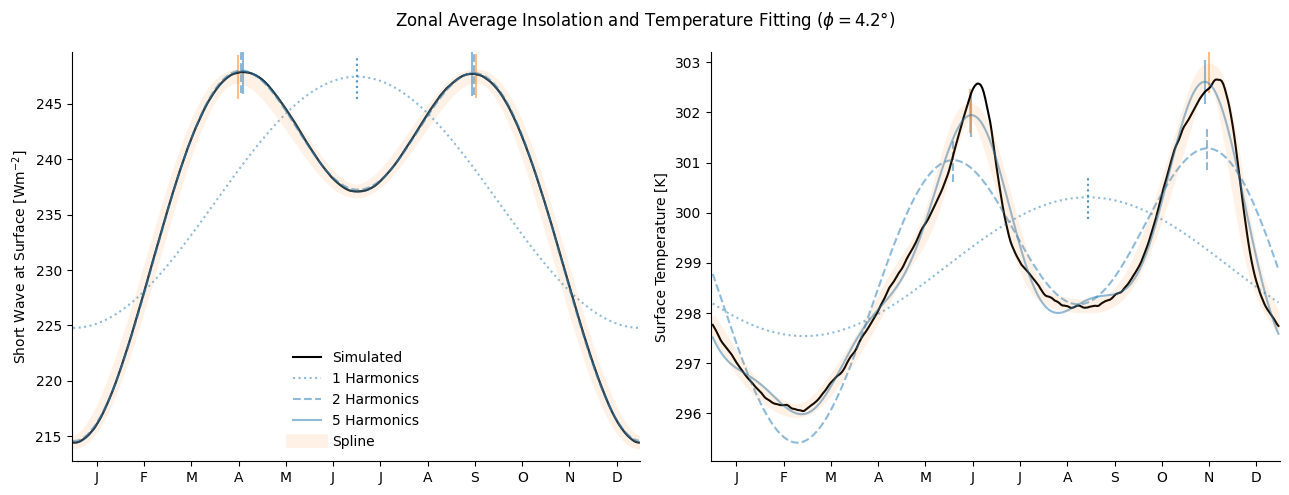

In [12]:
linestyle_harmonic = [':', '--', '-', '-.']
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1,2, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(time_array, ds_single_loc.swdn_sfc, color='k', label='Simulated')
for i in range(n_harmonics_single):
    ax[0].plot(time_array, sw_fourier_single[i], color=default_colors[0], linestyle=linestyle_harmonic[i], alpha=0.5,
               label=f"{harmonics_use_single[i]} Harmonics")
    for val in max_date_sw_fourier_single[i]:
        ax[0].scatter(val, sw_fourier_single[i][np.where(time_array==int(np.round(val))%n_year_days)],
                   color=default_colors[0], alpha=0.5, marker='|', s=1000, linestyle=linestyle_harmonic[i])
ax[0].plot(time_array, sw_spline_single(time_array), color=default_colors[1], lw=10, alpha=0.1, label="Spline")
for val in max_date_sw_spline_single:
    ax[0].scatter(val, sw_spline_single(val),
               color=default_colors[1], alpha=0.5, marker='|', s=1000)

ax[1].plot(time_array, ds_single_loc.t_surf, color='k')
for i in range(n_harmonics_single):
    ax[1].plot(time_array, temp_fourier_single[i], color=default_colors[0], linestyle=linestyle_harmonic[i], alpha=0.5)
    for val in max_date_temp_fourier_single[i]:
        ax[1].scatter(val, temp_fourier_single[i][np.where(time_array==int(np.round(val))%n_year_days)],
                   color=default_colors[0], alpha=0.5, marker='|', s=1000, linestyle=linestyle_harmonic[i])
ax[1].plot(time_array, temp_spline_single(time_array), color=default_colors[1], lw=10, alpha=0.1)
for val in max_date_temp_spline_single:
    ax[1].scatter(val, temp_spline_single(val),
               color=default_colors[1], alpha=0.5, marker='|', s=1000)
    
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].legend(frameon=False)
ax[0].set_ylabel('Short Wave at Surface [Wm$^{-2}$]')
ax[1].set_ylabel('Surface Temperature [K]')
fig.suptitle(f"Zonal Average Insolation and Temperature Fitting ($\phi={loc['lat']}\degree$)")
plt.tight_layout()

## Global Variation in Phase Delay
Below I plot how the phase delay between the maxima of insolation and insolation vary with latitude. 

The key point is that two or more harmonics are required to capture the trend for the phase delay to decrease with latitude.

In [13]:
n_time, n_lat = ds_global.swdn_sfc.shape
harmonics_use = [1, 2, 5]
n_harmonics = len(harmonics_use)
max_date_sw_fourier_global = np.zeros((n_lat, n_harmonics, 2))
max_date_temp_fourier_global = np.zeros((n_lat, n_harmonics, 2))
# Empty second axis so sort_max_date works
max_date_sw_spline_global = np.zeros((n_lat, 1, 2))     
max_date_temp_spline_global = np.zeros((n_lat, 1, 2))
with tqdm(total=n_lat*n_harmonics, position=0, leave=True) as pbar:
    for i, lat in enumerate(ds_global.lat):
        ds_use = ds_global.sel(lat=lat)
        max_date_sw_spline_global[i], max_date_temp_spline_global[i] = get_sw_temp_max_date(ds_use.time-0.5, ds_use.swdn_sfc, 
                                                                                            ds_use.t_surf)[:2]
        for j in range(n_harmonics):
            sw_fourier =  get_fourier_fit(time_array, ds_use.swdn_sfc, harmonics_use[j])[0]
            temp_fourier =  get_fourier_fit(time_array, ds_use.t_surf, harmonics_use[j])[0]
            # Use spacing of 1 for fourier maxima as want to know exact position of maxima in the fourier curves
            max_date_sw_fourier_global[i, j], max_date_temp_fourier_global[i, j] = get_sw_temp_max_date(time_array, sw_fourier, 
                                                                                                        temp_fourier, 1, 1)[:2]
            pbar.update(1)

# Sort spline max dates as have two dates for each latitude, want to ensure each date corresponds to correct one.
max_date_temp_fourier_global = sort_max_date(max_date_temp_fourier_global)
max_date_sw_fourier_global = sort_max_date(max_date_sw_fourier_global)
phase_delay_fourier_global = (max_date_temp_fourier_global - max_date_sw_fourier_global) % (n_year_days-1)     

max_date_temp_spline_global = np.squeeze(sort_max_date(max_date_temp_spline_global))
max_date_sw_spline_global = np.squeeze(sort_max_date(max_date_sw_spline_global))
phase_delay_spline_global = (max_date_temp_spline_global - max_date_sw_spline_global) % (n_year_days-1)     

# Make all phase shifts positive if temperature lags short wave
# phase_delay_simulated_global = -phase_delay_simulated_global % 359
# phase_delay_theory_global = -phase_delay_theory_global % 359
# phase_delay_lambda_theory_global = -phase_delay_lambda_theory_global % 359
# 
# # If difference is more than half a year, say that temperature response leads shortwave response
phase_delay_fourier_global[phase_delay_fourier_global>n_year_days/2] -= (n_year_days-1)
phase_delay_spline_global[phase_delay_spline_global>n_year_days/2] -= (n_year_days-1)
# phase_delay_theory_global[phase_delay_theory_global>180] -= 359
# phase_delay_lambda_theory_global[phase_delay_lambda_theory_global>180] -=359

100%|██████████| 192/192 [00:01<00:00, 175.72it/s]


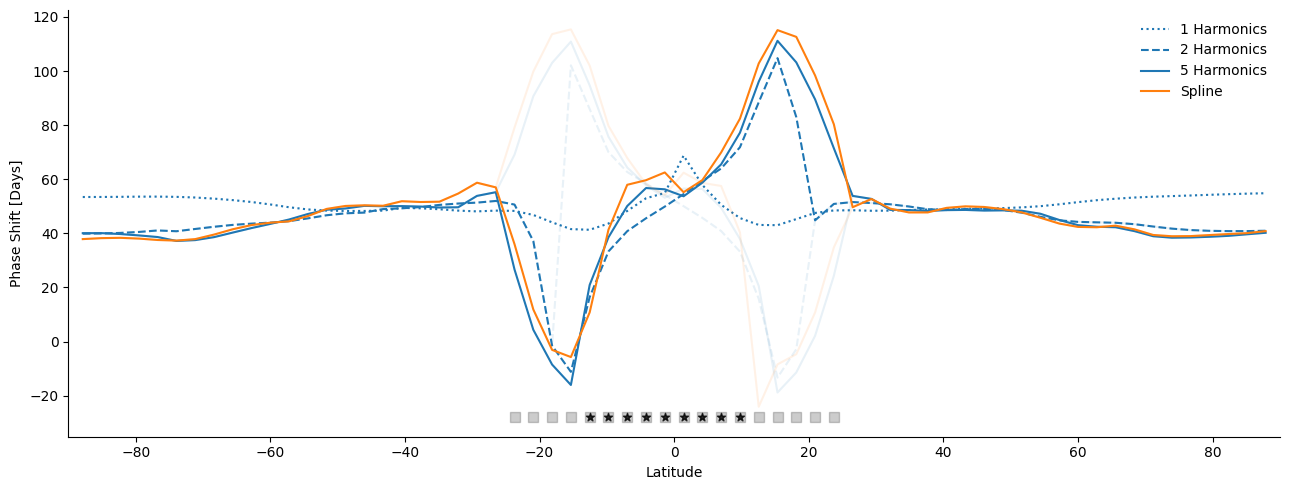

In [143]:
fig_phase, ax = plt.subplots(1,1, figsize=(13, 5))
ax.spines[['top', 'right']].set_visible(False)
for i in range(n_harmonics):
    ax.plot(ds_global.lat, phase_delay_fourier_global[:,i,0], color=default_colors[0], linestyle=linestyle_harmonic[i], 
            label=f"{harmonics_use[i]} Harmonics")
    ax.plot(ds_global.lat, phase_delay_fourier_global[:,i,1], color=default_colors[0], linestyle=linestyle_harmonic[i], alpha=0.1)
ax.plot(ds_global.lat, phase_delay_spline_global[:, 0], color=default_colors[1], label='Spline')
ax.plot(ds_global.lat, phase_delay_spline_global[:, 1], color=default_colors[1], alpha=0.1)

# Record where two maxima are found for insolation (*) and temperature (□)
symbol_y_val = np.floor(phase_delay_spline_global.min()-3)
two_sw_maxima = max_date_sw_spline_global[:, 0] != max_date_sw_spline_global[:, 1]
ax.scatter(ds_global.lat[two_sw_maxima], [symbol_y_val]*np.sum(two_sw_maxima), alpha=0.8, marker='*', color='k')
two_temp_maxima = max_date_temp_spline_global[:, 0] != max_date_temp_spline_global[:, 1]
ax.scatter(ds_global.lat[two_temp_maxima], [symbol_y_val]*np.sum(two_temp_maxima), alpha=0.2, marker='s', color='k', s=50)

ax.set_xlim(-90,90)
ax.legend(frameon=False)
ax.set_xlabel('Latitude')
ax.set_ylabel('Phase Shift [Days]')
plt.tight_layout()

In [15]:
def get_temp_fourier_coefs(sw_fourier_amp, sw_fourier_phase, lambda_const, heat_capacity, n_year_days=n_year_days):
    # This assumes the equation CdT/dt = F(t) - lambda*T
    freq = 1/(n_year_days*24*60**2)
    amp_coef = np.zeros_like(sw_fourier_amp)
    phase_coef = np.zeros_like(sw_fourier_phase)
    amp_coef[0] = lambda_const * sw_fourier_amp[0]
    for i in range(len(phase_coef)):
        phase_coef[i] = np.arctan((lambda_const*np.tan(sw_fourier_phase[i]) + 2*np.pi*freq*heat_capacity)/
                                  (lambda_const - 2*np.pi*freq*heat_capacity*np.tan(sw_fourier_phase[i])))
        amp_coef[i+1] = sw_fourier_amp[i+1]*np.cos(sw_fourier_phase[i])/(
                2*np.pi*freq*heat_capacity*np.sin(phase_coef[i])+lambda_const * np.cos(phase_coef[i]))
    return amp_coef, phase_coef


In [100]:
get_fourier_fit(time_array, ds_global.sel(lat=90,method='nearest').swdn_sfc, 2)[1:]

(array([ 199.14838888, -156.11123761,   65.92789279]),
 array([-0.00372543, -0.00240038]))

In [24]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
a, b = get_fourier_fit(time_array, ds_single_loc.swdn_sfc, 2)[1:]
a[0] = 0        # as the theory predicts the variation in the mean
b[:] = 0
a_temp, b_temp = get_temp_fourier_coefs(a, b, 4.18, heat_capacity)
temp_approx = fourier_series(time_array, a_temp, b_temp) + np.mean(ds_single_loc.t_surf)


In [135]:
def get_lambda(dataset):
    gamma_flux = dataset.lwdn_sfc - dataset.lwup_sfc - dataset.flux_lhe - dataset.flux_t 
    lambda_const, beta_const, r_squared, _, _ = scipy.stats.linregress(dataset.t_surf-np.mean(dataset.t_surf),
                                                                       gamma_flux - np.mean(gamma_flux))
    return -lambda_const, beta_const, r_squared

# def get_sw_amp_ratio(dataset):
#     a, b = get_fourier_fit(time_array, ds_single_loc.swdn_sfc, 2)[1]

In [151]:
def get_temp_maxima_date_from_lambda(sw_amp_ratio_array, lambda_const_array, time=time_array,
                                     hemisphere = 'north', heat_capacity=heat_capacity, n_year_days=n_year_days):
    time = np.append(time, time[-1]+1)
    maxima_date = np.zeros((len(sw_amp_ratio_array), len(lambda_const_array), 2))
    sw_phase_coefs = np.zeros(2)        # assume shortwave phase shift is zero for all harmonics to simplify and makes little difference
    sw_amp_coefs = np.zeros(3)          # First coefficient is zero as only interested in where maxima is not actual value
    
    # Negative value means northern hemisphere (minima in January), negative means southern hemisphere (maxima in January)
    if hemisphere == 'north':
        sw_amp_coefs[1] = -1         # Note the value of this is irrelevent as only the ratio affects the date of the maxima.
    else:
        sw_amp_coefs[1] = 1                         
    with tqdm(total=np.product(maxima_date.shape[:2]), position=0, leave=True) as pbar: 
        for i, sw_amp_ratio in enumerate(sw_amp_ratio_array):
            sw_amp_coefs[2] = sw_amp_coefs[1] * sw_amp_ratio
            for j, lambda_const in enumerate(lambda_const_array):
                temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(sw_amp_coefs, sw_phase_coefs, lambda_const, heat_capacity,
                                                                          n_year_days)
                temp_fourier_approx = fourier_series(time_array, temp_amp_coefs, temp_phase_coefs)
                temp_approx_spl = CubicSpline(time, np.append(temp_fourier_approx, temp_fourier_approx[0]), bc_type='periodic')
                maxima_date[i, j] = get_maxima_date_from_spline(temp_approx_spl)
                pbar.update(1)
    return maxima_date

In [148]:
lambda_const_array = np.arange(-1,6, 0.05)
sw_amp_ratio_array = np.arange(-1.2,2, 0.02)
max_date_temp_empirical_exhaustive = get_temp_maxima_date_from_lambda(sw_amp_ratio_array, lambda_const_array)
# Sort so the first maxima is in NH winter if there are two maxima
max_date_temp_empirical_exhaustive[max_date_temp_empirical_exhaustive>330] -= n_year_days       # If in last month, make this the first maxima
max_date_temp_empirical_exhaustive = np.sort(max_date_temp_empirical_exhaustive, axis=2)
max_date_temp_empirical_exhaustive[max_date_temp_empirical_exhaustive<0] += n_year_days

100%|██████████| 22400/22400 [00:20<00:00, 1118.85it/s]


In [149]:
# Get the value of lambda and ratio of 2nd to 1st harmonic at each latitude
lambda_lat = np.zeros(n_lat)
sw_ratio_lat = np.zeros(n_lat)
for i, lat in enumerate(ds_global.lat):
    ds_use = ds_global.sel(lat=ds_global.lat[i])
    lambda_lat[i] = get_lambda(ds_use)[0]
    a = get_fourier_fit(time_array, ds_use.swdn_sfc, 2)[1]
    sw_ratio_lat[i] = a[2]/a[1]

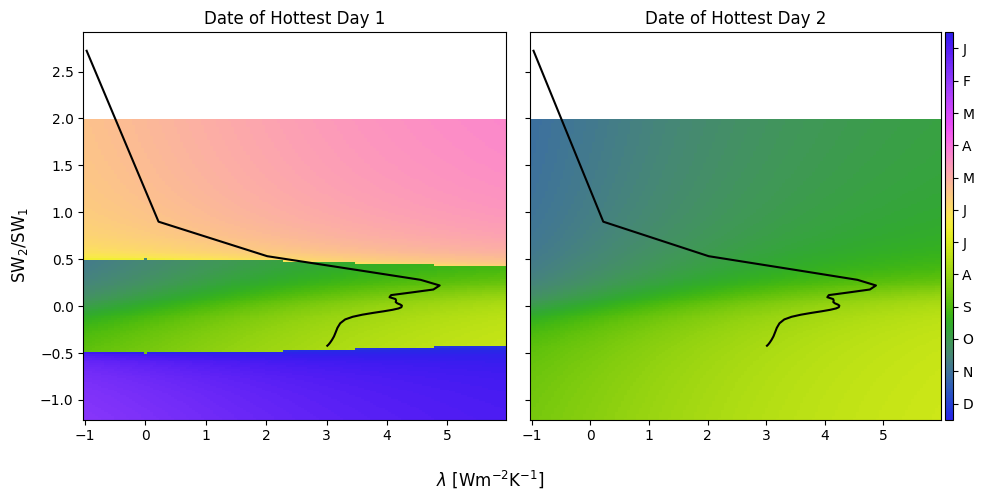

In [150]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
im  = ax[0].pcolormesh(lambda_const_array, sw_amp_ratio_array, max_date_temp_empirical_exhaustive[:, :, 0],
                     cmap=colorcet.cm.colorwheel, vmin=0, vmax=360)
cbar = plt.colorbar(im, ticks=month_ticks[0], ax=ax[1], aspect=50, pad=0.01, fraction=0.02)
cbar.ax.set_yticklabels(month_ticks[1])
cbar.ax.invert_yaxis()
fig.supxlabel('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
fig.supylabel('SW$_2$/SW$_1$')
ax[0].set_title('Date of Hottest Day 1')
im  = ax[1].pcolormesh(lambda_const_array, sw_amp_ratio_array, max_date_temp_empirical_exhaustive[:, :, 1],
                     cmap=colorcet.cm.colorwheel, vmin=0, vmax=360)
for i in range(2):
    ax[i].plot(lambda_lat[ds_global.lat>0], sw_ratio_lat[ds_global.lat>0], color='k')
ax[1].set_title('Date of Hottest Day 2')
plt.tight_layout()

In [152]:
def get_temp_maxima_date_lambda_empirical(dataset, zero_phase=True, n_harmonics=2, time=time_array, 
                                          heat_capacity=heat_capacity, n_year_days=n_year_days):
    lambda_const = get_lambda(dataset)[0]
    sw_amp_coefs, sw_phase_coefs = get_fourier_fit(time_array, ds_use.swdn_sfc, n_harmonics)[1:3]
    if zero_phase:
        sw_phase_coefs[:] = 0
    sw_amp_coefs[0] = 0             # First coefficient is zero as only interested in where maxima is not actual value
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(sw_amp_coefs, sw_phase_coefs, lambda_const, heat_capacity, n_year_days)
    temp_fourier_approx = fourier_series(time_array, temp_amp_coefs, temp_phase_coefs)
    temp_approx_spl = CubicSpline(np.append(time, time[-1]+1), np.append(temp_fourier_approx, temp_fourier_approx[0]), bc_type='periodic')
    maxima_date = np.zeros(2)
    maxima_date[:] = get_maxima_date_from_spline(temp_approx_spl)

    return maxima_date

In [189]:
max_date_temp_empirical_global = np.zeros((n_lat, 2, 2))
with tqdm(total=n_lat, position=0, leave=True) as pbar:
    for i, lat in enumerate(ds_global.lat):
        ds_use = ds_global.sel(lat=lat)
        max_date_temp_empirical_global[i, 0, :] = get_temp_maxima_date_lambda_empirical(ds_use, zero_phase=False, n_harmonics=2)
        max_date_temp_empirical_global[i, 1, :] = get_temp_maxima_date_lambda_empirical(ds_use, zero_phase=True, n_harmonics=2)
        pbar.update(1)
        
max_date_temp_empirical_global = sort_max_date(max_date_temp_empirical_global)
phase_delay_empirical_global = (max_date_temp_empirical_global - np.expand_dims(max_date_sw_spline_global,1)) % (n_year_days-1)      
# If difference is more than half a year, say that temperature response leads shortwave response
phase_delay_empirical_global[phase_delay_empirical_global>n_year_days/2] -= (n_year_days-1)

100%|██████████| 64/64 [00:00<00:00, 108.41it/s]


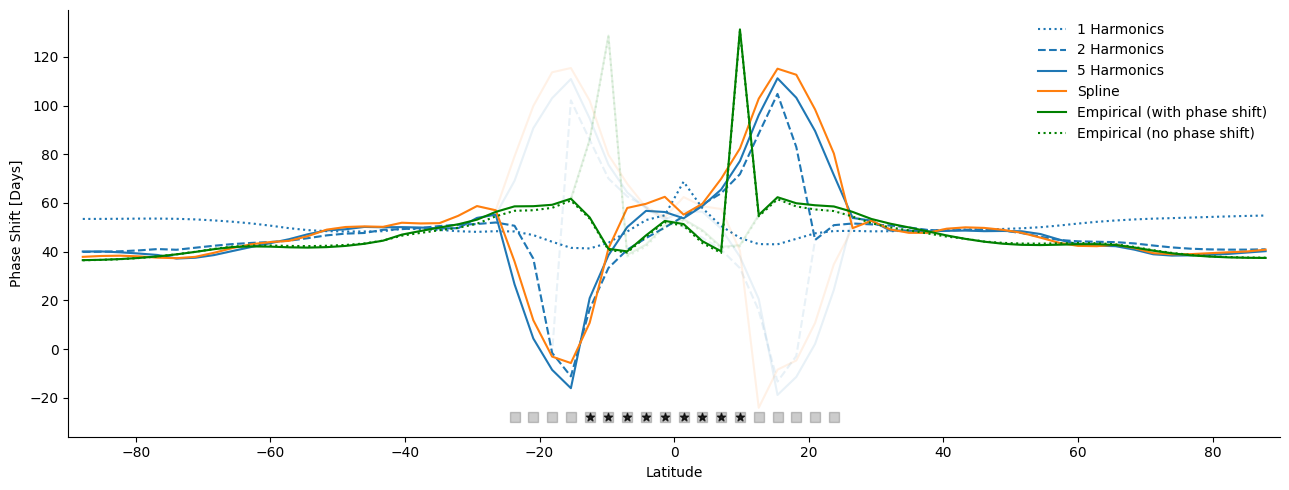

In [190]:
fig = copy.deepcopy(fig_phase)
ax = fig.gca()
ax.plot(ds_global.lat, phase_delay_empirical_global[:, 0, 1], color='g', label='Empirical (with phase shift)')
ax.plot(ds_global.lat, phase_delay_empirical_global[:, 0, 0], color='g', alpha=0.1)
ax.plot(ds_global.lat, phase_delay_empirical_global[:, 1, 1], color='g', linestyle=':', label='Empirical (no phase shift)')
ax.plot(ds_global.lat, phase_delay_empirical_global[:, 1, 0], color='g', linestyle=':', alpha=0.1)
ax.legend(frameon=False)
fig